# Helpful (hopefully) notes and general measurement tips

- **Spectrum Analyzer:** The spectrum analyzer tends to timeout if it hasn't been used in a while. To restart it, simply execute the qubit initialization again or use the qb._instrument.set() command to send a value and wake the instrument back up.
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qubit import qubit
import numpy as np
import plot_functions as pf
# from instrument_init import init_sa

2024-04-05 11:03:11,023 - qm - INFO     - Starting session: f21f1115-9fb8-47e9-bc89-345fab17c8b1


# Initialize qubit

In [154]:
qb = qubit('q1-testing')

Loading parameter JSON file
2024-04-05 13:14:48,493 - qm - INFO     - Performing health check
2024-04-05 13:14:48,504 - qm - INFO     - Health check passed
Loading instrument settings from experiments\test\test_instruments.json.
Initializing readout_LO (BNC 845 Signal Generator).
Initializing qubit_LO (SignalCore SC5506A Signal Generator).
Initializing DA (Vaunix Lab Brick Digital Attenuator).
Initializing sa (SignalHound SpectrumAnalyzer).
Setting readout_LO frequency to 6414000000.0.
Setting readout_LO output to True.
Setting qubit_LO frequency to 5800000000.0.
Setting qubit_LO power to 17.
Setting qubit_LO output to True.
Setting DA attenuation to 0.


# Time of flight

Updating readout_atten to 0
Setting DA attenuation to 0.
Updating tof to 256
Updating smearing to 10
Updating n_avg to 1000
Updating rr_IF to 5000000.0
Updating readout_length to 1000
2024-04-05 12:19:43,056 - qm - INFO     - Performing health check
2024-04-05 12:19:43,068 - qm - INFO     - Health check passed
2024-04-05 12:19:43,200 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:19:43,337 - qm - INFO     - Executing program
Input 1 Offset: 0.007861567478553546 mV
Input 2 Offset: 0.08950769761029437 mV
Updating analog_input_offsets to [0.0490114507317173, 0.06109872896603387]


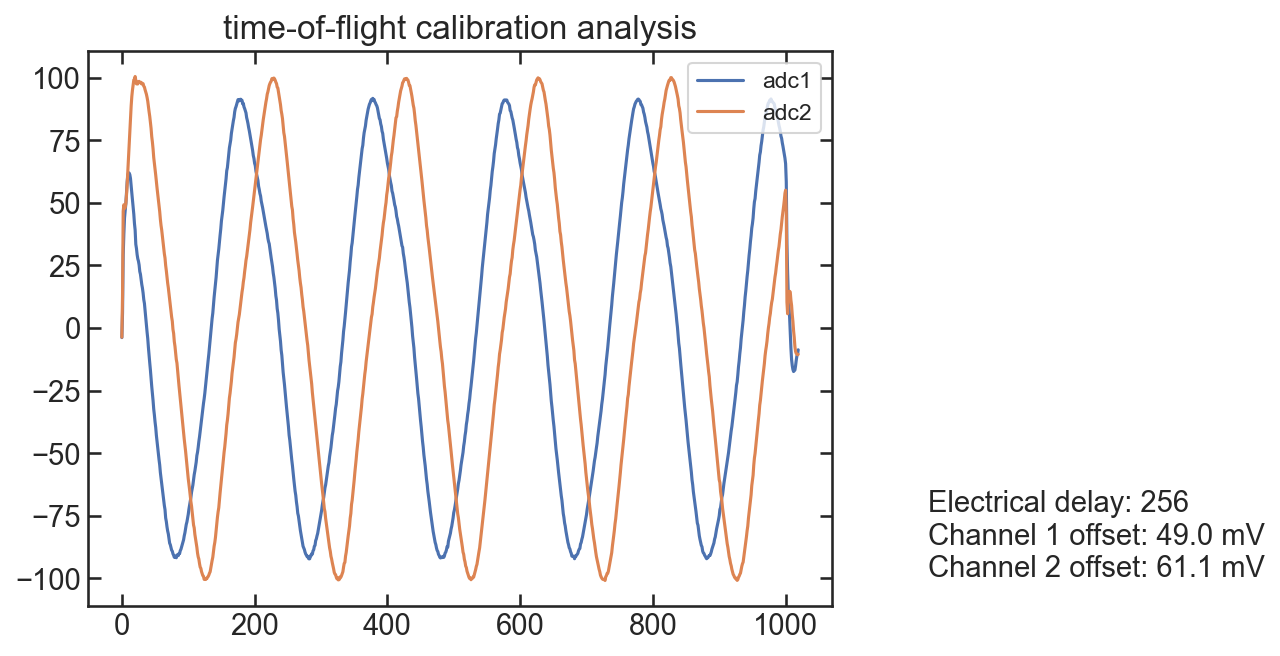

In [111]:
qb.update_value('readout_atten',0)
qb.update_value('tof',256)
qb.update_value('smearing',10)
qb.update_value('n_avg',1000)
qb.update_value('rr_IF',5e6)
qb.update_value('readout_length',1000)

adc1,adc2 = qb.tof_cal(update_tof=False)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

# Optimize Mixers

## Minimize LO leakage 

Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 6400000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.
LO at 6.4 GHz
Current I_offset = -12.3 mV, Current Q_offset = 4.7 mV
Setting sa frequency to 6400000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -28.266643524169922.
Setting sa bandwidth to 1000.0.


100%|██████████| 121/121 [00:13<00:00,  9.12it/s]


Updating rr_mixer_offsets to [-0.01239999999999997, 0.004600000000000003]
optimal I_offset = -12.4 mV, optimal Q_offset = 4.6 mV
Updating readout_atten to 30
Setting DA attenuation to 30.
Power: -75.82210540771484 dBm at 6.4 GHz


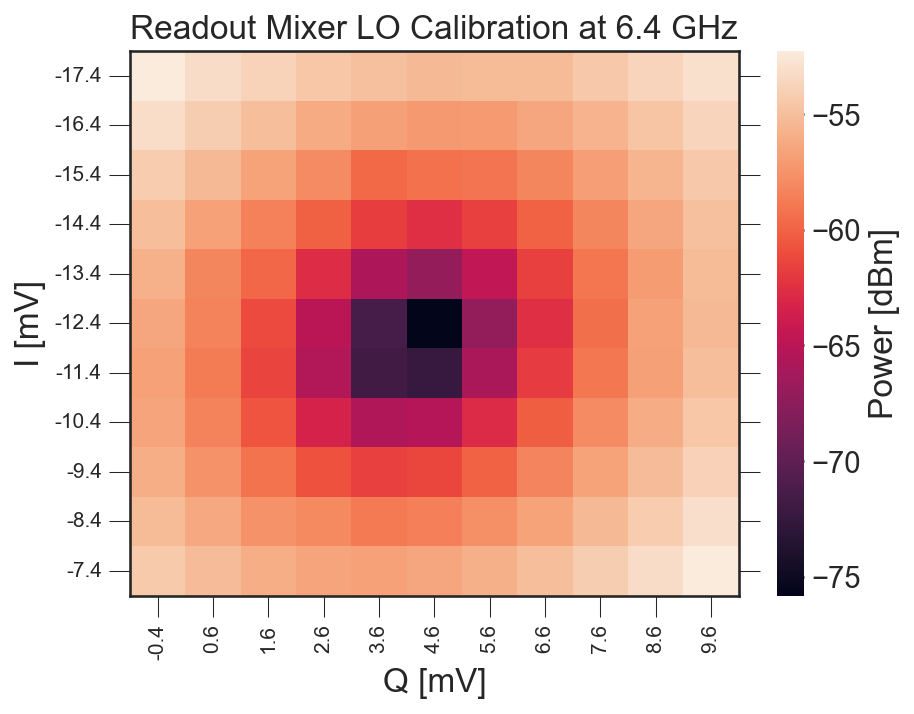

In [96]:
qb.update_value('rr_LO',6.4e9)
# qb.get_power(fc=qb.pars['rr_LO'],threshold=-20,span=1e6,config=True,plot=True)
qb.opt_lo_leakage(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

In [ ]:
qb.opt_lo_leakage(mode='fine',element='rr',sa_span=0.5e6,threshold=-50,plot=True)

## Minimize image sideband

Updating rr_IF to 50000000.0
2024-04-05 11:44:24,597 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 11:44:24,733 - qm - INFO     - Executing program
Updating readout_atten to 0
Setting DA attenuation to 0.
Setting sa frequency to 6350000000.0.
Setting sa span to 500000.0.
Setting sa threshold to -20.
Setting sa bandwidth to 1000.0.


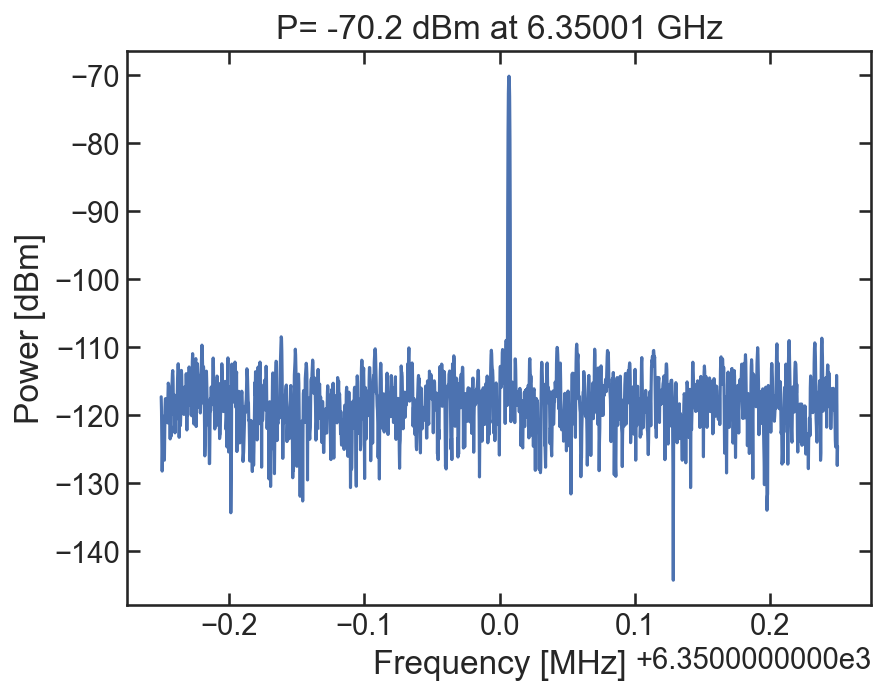

-70.175048828125 dBm at 6.350006923282206 GHz
Sideband at 6.35 GHz
Current gain = -0.0111, Current phase = -0.0833


100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


Updating rr_mixer_imbalance to (0.0, -0.05555555555555558)
optimal gain = 0.0, optimal phi = -0.0556
Updating readout_atten to 30
Setting DA attenuation to 30.
Power: -66.23970794677734 dBm at 6.35 GHz


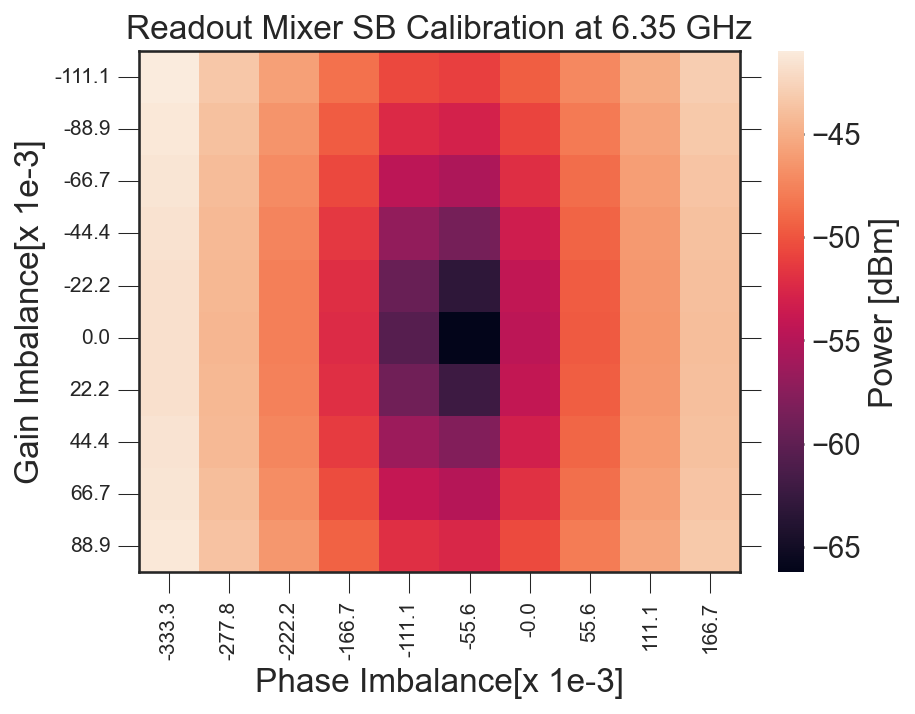

In [97]:
qb.update_value('rr_IF',50e6)
qb.opt_sideband(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

In [ ]:
qb.opt_sideband(mode='fine',element='rr',sa_span=0.5e6,threshold=-50,plot=True)

# Resonator spectroscopy

**Notes on resonator spectroscopy**

In [158]:
# qb.update_value('readout_length', 1000)   ##wanted a clearer peak
# qb.update_value('tof',252)
# qb.update_value('smearing',60)
# qb.update_value('rr_resettime',8000)
# qb.pars['resettime']['rr'] = 2000
qb.write_pars()
# qb.update_value('n_avg',1000)
# qb.update_value('readout_atten',30)
df_resonator_spec = 0.25e6
qb.experiment = 'resonator_spec'
##added a 10db fixed attenuator on rr line after the spiltter and just before fridge input
data, job = qb.resonator_spec(
                       f_LO = 6.4e9,
                       IF_min = 20e6,
                       IF_max = 100e6,
                       df = df_resonator_spec,
                       fit=True,
                       on_off=False,
                       savedata=False,
                       showprogress=True)

Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 13:15:39,181 - qm - INFO     - Performing health check
2024-04-05 13:15:39,193 - qm - INFO     - Health check passed
2024-04-05 13:15:39,312 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 13:15:39,382 - qm - INFO     - Executing program


100%|█████████▉| 4999/5000 [00:20<00:00, 247.62it/s]


Resonant Frequency: 6.46525 GHz
FWHM = nan MHz
kappa = nan MHz


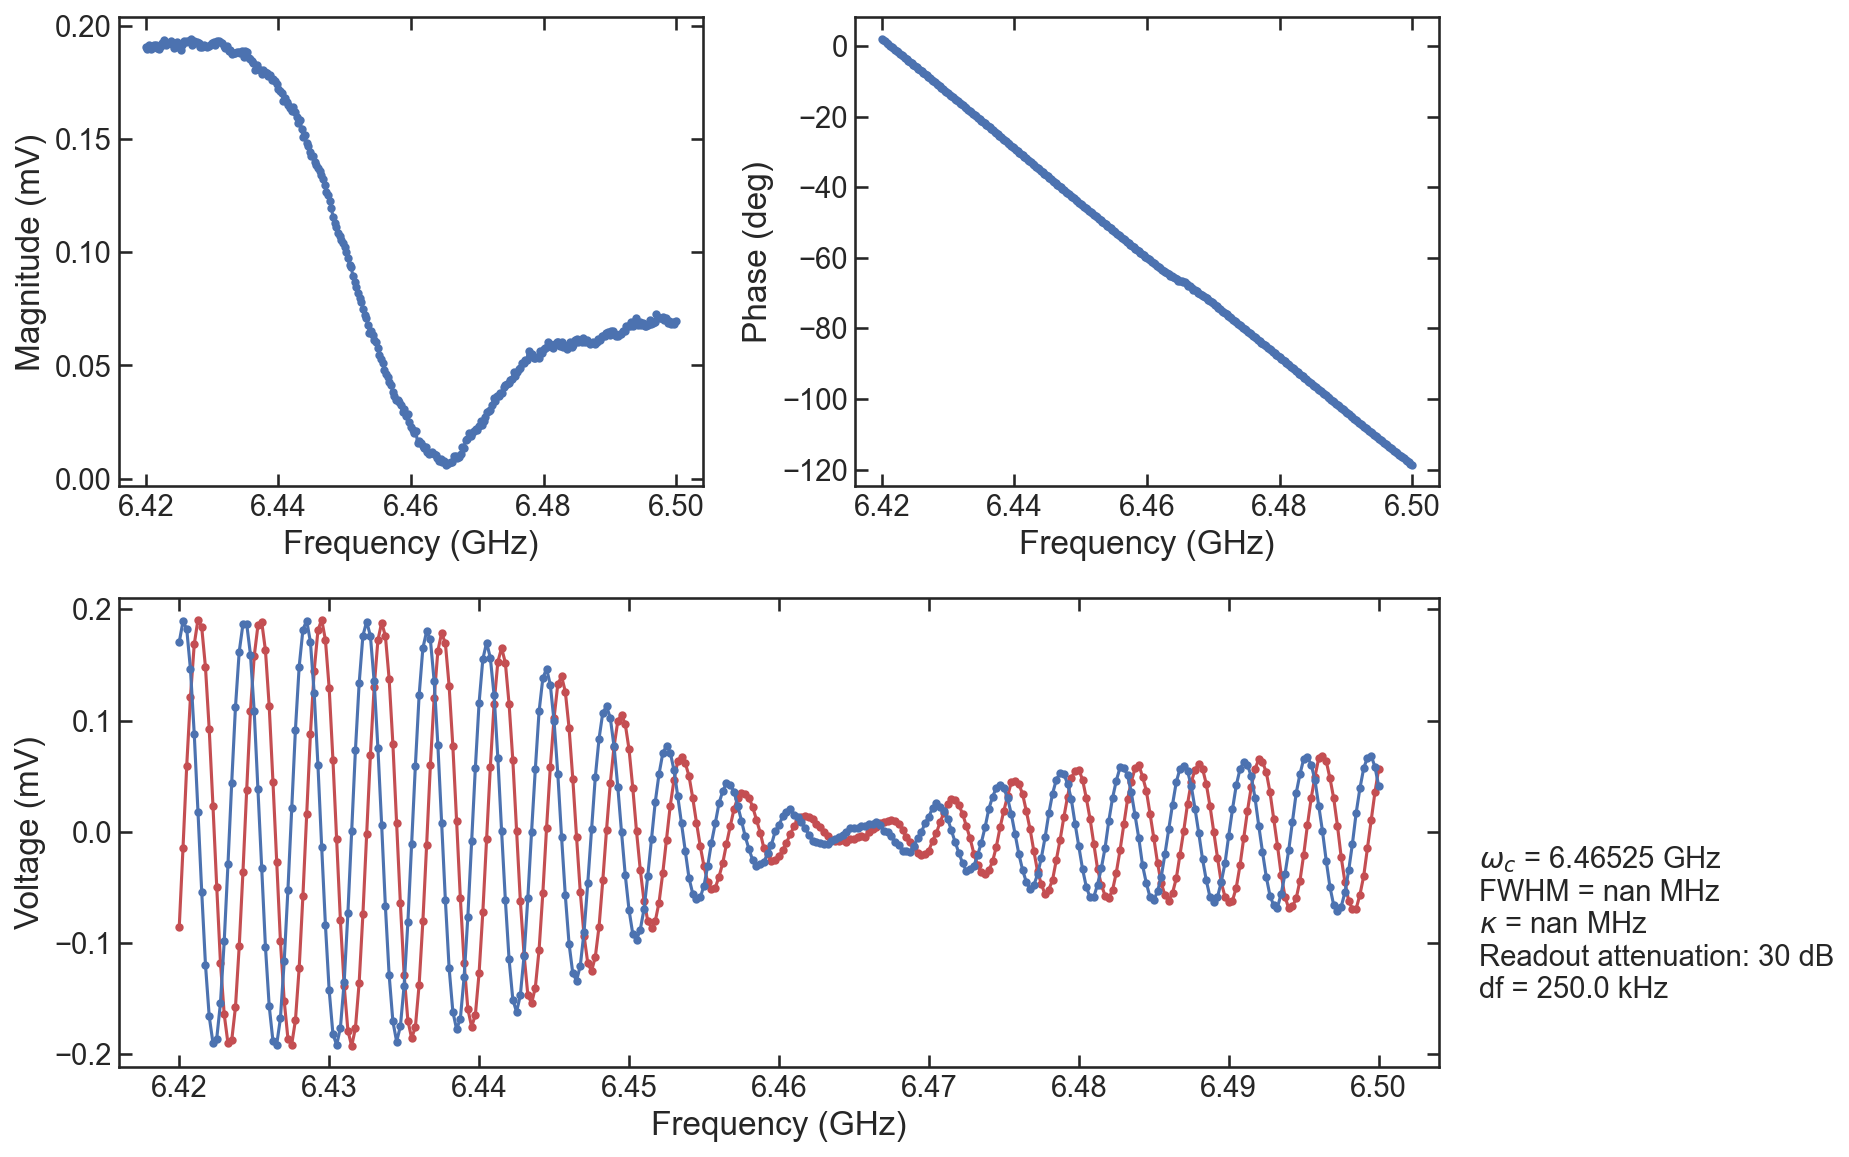

In [113]:
fc,fwhm = pf.fit_res(data['freqs'],data['I'],data['Q'])
pf.resonator_spec_plot(data,qb_pars=qb.pars,fwhm=fwhm,fc=fc)

# Qubit Punchout

**Notes on qubit punchout**

In [117]:
attenuations = np.arange(0,50,5)
qb.update_value('n_avg',5000)
data, job = qb.punchout(df = 0.25e6,
                 IF_min = 45e6,
                 IF_max = 75e6,
                 attenuations=attenuations,
                 savedata=False)

Updating n_avg to 5000


  0%|          | 0/10 [00:00<?, ?it/s]

Attenuation = 0 dB
Setting DA attenuation to 0.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:26:48,725 - qm - INFO     - Performing health check
2024-04-05 12:26:48,737 - qm - INFO     - Health check passed
2024-04-05 12:26:48,834 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:26:48,897 - qm - INFO     - Executing program


 10%|█         | 1/10 [00:08<01:14,  8.24s/it]

Attenuation = 5 dB
Setting DA attenuation to 5.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:26:56,965 - qm - INFO     - Performing health check
2024-04-05 12:26:56,978 - qm - INFO     - Health check passed
2024-04-05 12:26:57,087 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:26:57,150 - qm - INFO     - Executing program


 20%|██        | 2/10 [00:16<01:05,  8.22s/it]

Attenuation = 10 dB
Setting DA attenuation to 10.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:27:05,166 - qm - INFO     - Performing health check
2024-04-05 12:27:05,178 - qm - INFO     - Health check passed
2024-04-05 12:27:05,284 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:27:05,493 - qm - INFO     - Executing program


 30%|███       | 3/10 [00:24<00:57,  8.24s/it]

Attenuation = 15 dB
Setting DA attenuation to 15.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:27:13,452 - qm - INFO     - Performing health check
2024-04-05 12:27:13,464 - qm - INFO     - Health check passed
2024-04-05 12:27:13,575 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:27:13,646 - qm - INFO     - Executing program


 40%|████      | 4/10 [00:32<00:49,  8.25s/it]

Attenuation = 20 dB
Setting DA attenuation to 20.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:27:21,681 - qm - INFO     - Performing health check
2024-04-05 12:27:21,716 - qm - INFO     - Health check passed
2024-04-05 12:27:21,818 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:27:21,882 - qm - INFO     - Executing program


 50%|█████     | 5/10 [00:41<00:41,  8.24s/it]

Attenuation = 25 dB
Setting DA attenuation to 25.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:27:30,068 - qm - INFO     - Performing health check
2024-04-05 12:27:30,082 - qm - INFO     - Health check passed
2024-04-05 12:27:30,240 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:27:30,307 - qm - INFO     - Executing program


 60%|██████    | 6/10 [00:49<00:33,  8.32s/it]

Attenuation = 30 dB
Setting DA attenuation to 30.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:27:38,374 - qm - INFO     - Performing health check
2024-04-05 12:27:38,386 - qm - INFO     - Health check passed
2024-04-05 12:27:38,483 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:27:38,550 - qm - INFO     - Executing program


 70%|███████   | 7/10 [00:57<00:24,  8.27s/it]

Attenuation = 35 dB
Setting DA attenuation to 35.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:27:46,553 - qm - INFO     - Performing health check
2024-04-05 12:27:46,564 - qm - INFO     - Health check passed
2024-04-05 12:27:46,671 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:27:46,737 - qm - INFO     - Executing program


 80%|████████  | 8/10 [01:06<00:16,  8.26s/it]

Attenuation = 40 dB
Setting DA attenuation to 40.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:27:54,809 - qm - INFO     - Performing health check
2024-04-05 12:27:54,821 - qm - INFO     - Health check passed
2024-04-05 12:27:54,944 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:27:55,031 - qm - INFO     - Executing program


 90%|█████████ | 9/10 [01:14<00:08,  8.26s/it]

Attenuation = 45 dB
Setting DA attenuation to 45.
Updating rr_LO to 6400000000.0
Setting readout_LO frequency to 6400000000.0.
2000
2024-04-05 12:28:03,066 - qm - INFO     - Performing health check
2024-04-05 12:28:03,096 - qm - INFO     - Health check passed
2024-04-05 12:28:03,210 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 12:28:03,278 - qm - INFO     - Executing program


100%|██████████| 10/10 [01:22<00:00,  8.26s/it]

Setting DA attenuation to 30.


Dispersive shift: -0.0 kHz
Resonant Frequency: 0.00000 GHz
FWHM = nan MHz
kappa = nan MHz
Resonant Frequency: 0.00000 GHz
FWHM = nan MHz
kappa = nan MHz


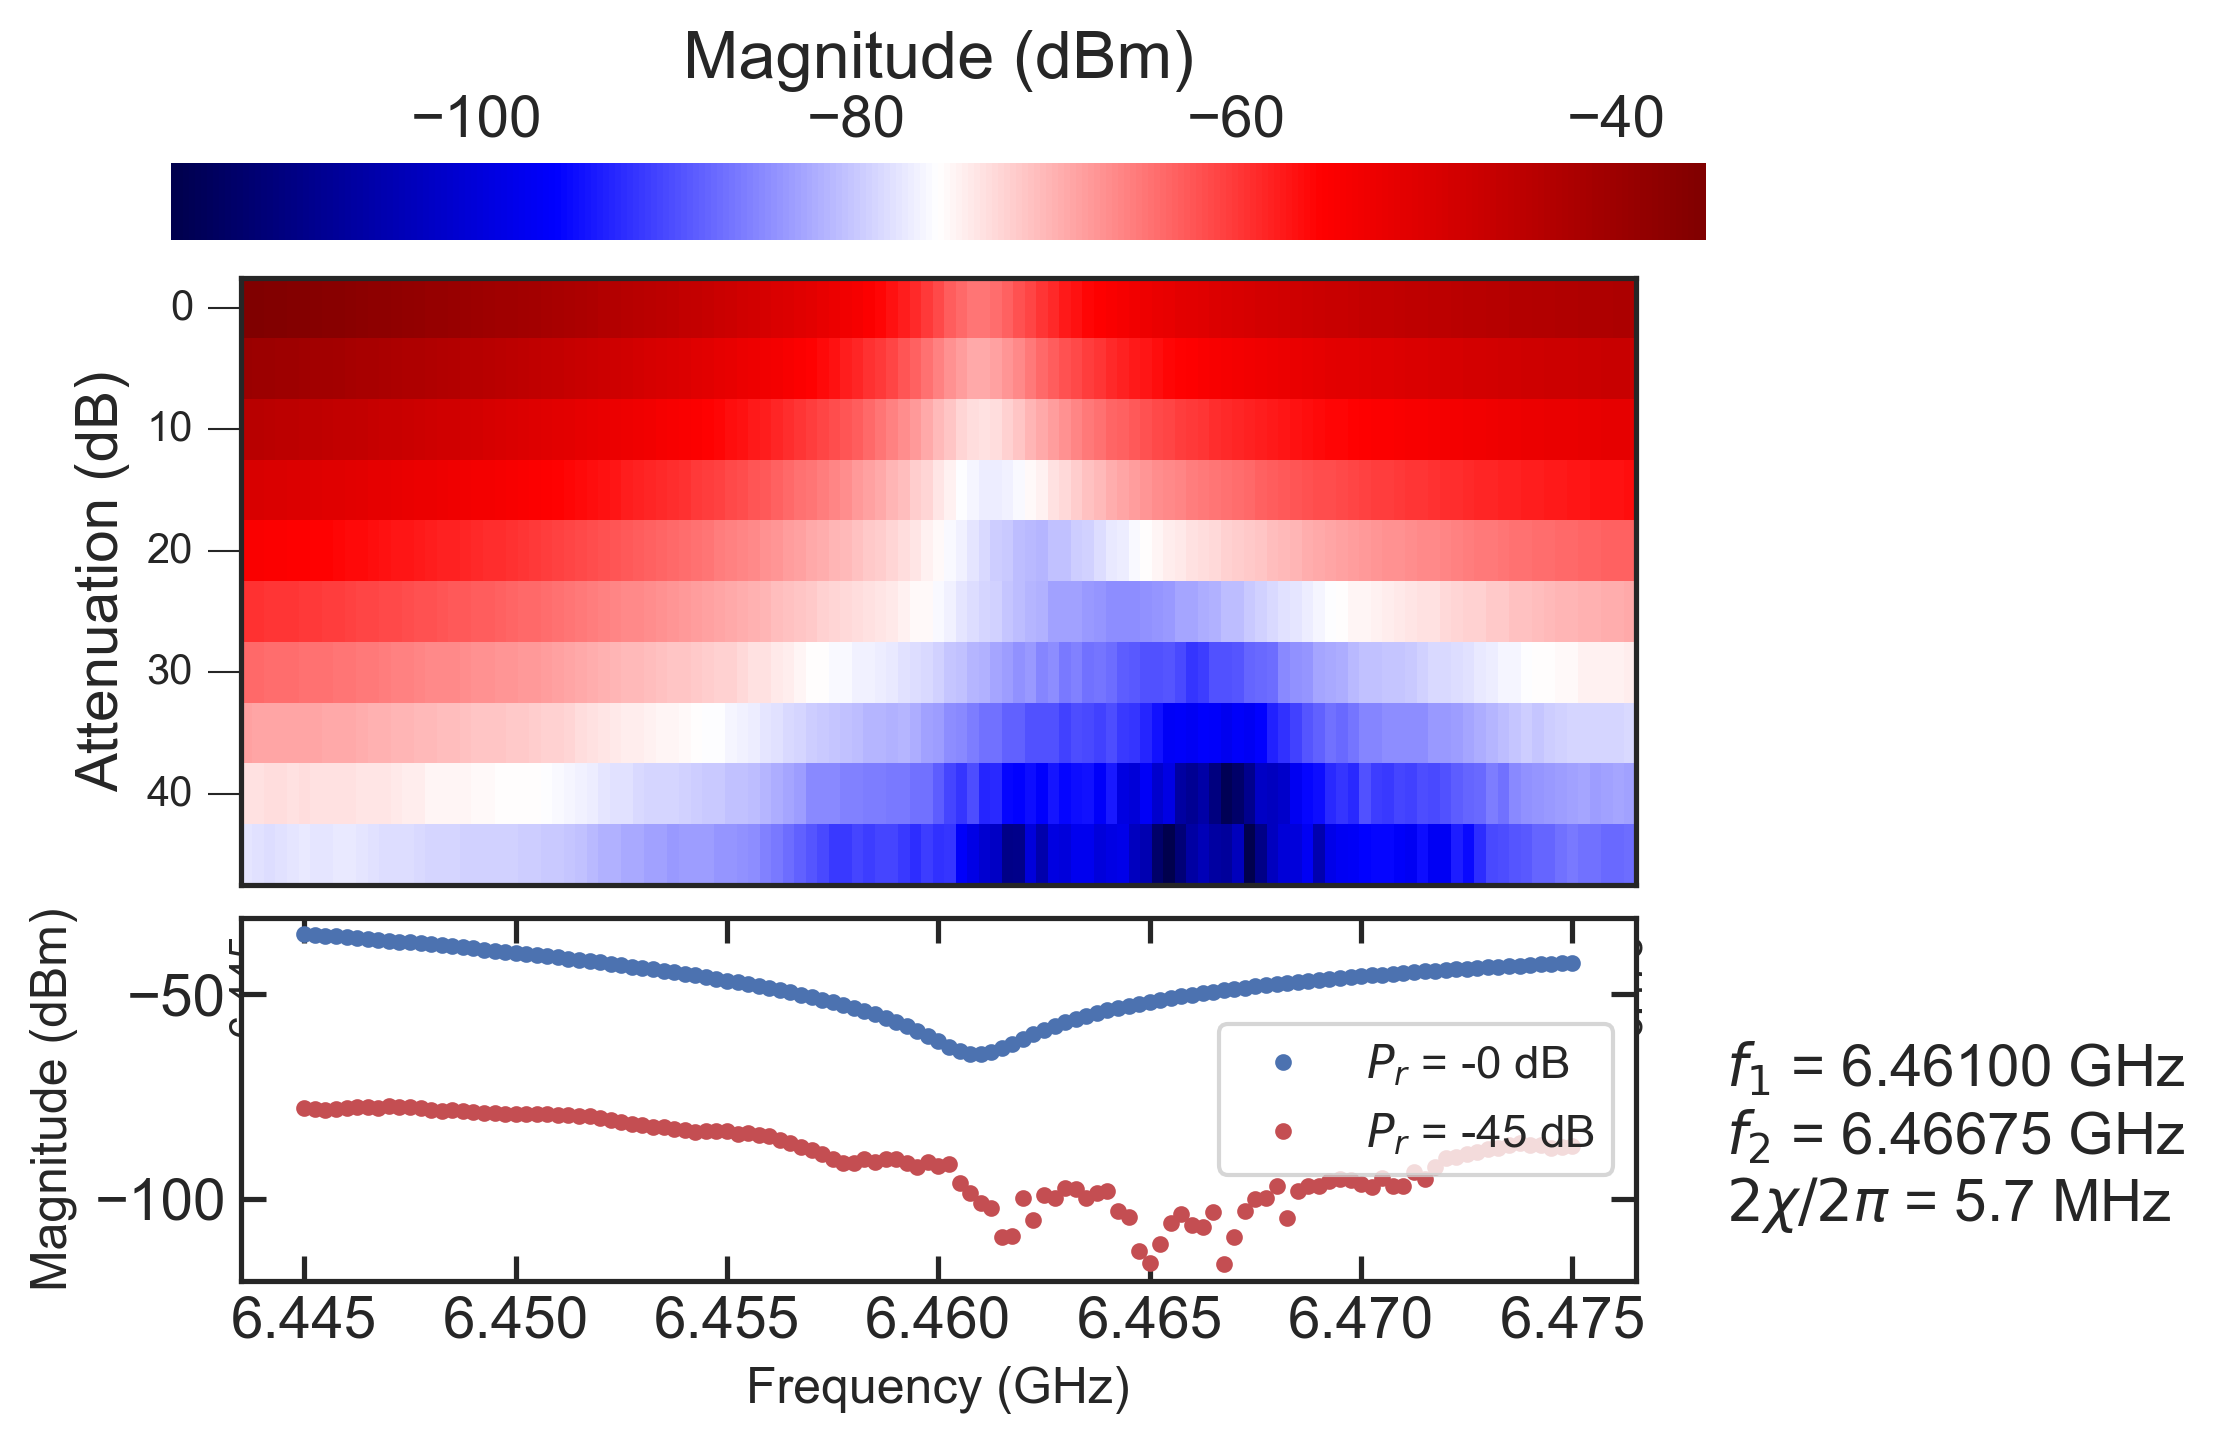

In [118]:
pf.punchout_plot(data,xlabel='Frequency (GHz)',ylabel='Attenuation (dB)',cbar_label='Magnitude (dBm)')

In [155]:
qb.update_value('readout_atten',30)

Updating readout_atten to 30
Setting DA attenuation to 30.


# Qubit Spectroscopy

In [176]:
amp_q_scaling = 0.1
qb.update_value('n_avg',5000)
qb.update_value('rr_freq', 6.465e9)
# qb.update_value('rr_IF', 50e6)
# qb.update_value('smearing',40)
# qb.update_value('tof',292)
qb.update_value('readout_atten',24)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(20e3)
qb.write_pars()
qb.experiment = 'qubit_spec'
data, job = qb.qubit_spec(element='qubit',
                                check_mixers=False,
                                IF_min=70e6,
                                IF_max=85e6,
                                f_LO=6e9,
                                df=0.1e6,
                                on_off=True,
                                amp_q_scaling = amp_q_scaling,
                                saturation_dur = 20e3,
                                showprogress=True,
                                savedata=False)

Updating n_avg to 5000
Updating rr_freq to 6465000000.0
Updating readout_atten to 24
Setting DA attenuation to 24.
Updating rr_LO to 6415000000.0
Setting readout_LO frequency to 6415000000.0.
Updating qubit_LO to 6000000000.0
Setting qubit_LO frequency to 6000000000.0.
2024-04-05 13:46:29,832 - qm - INFO     - Performing health check
2024-04-05 13:46:29,844 - qm - INFO     - Health check passed
2024-04-05 13:46:29,945 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 13:46:30,040 - qm - INFO     - Executing program


100%|█████████▉| 4999/5000 [02:07<00:00, 39.10it/s]


Peak threshold at 0.0035080012880052977
Peaks at: 6.0796 GHz



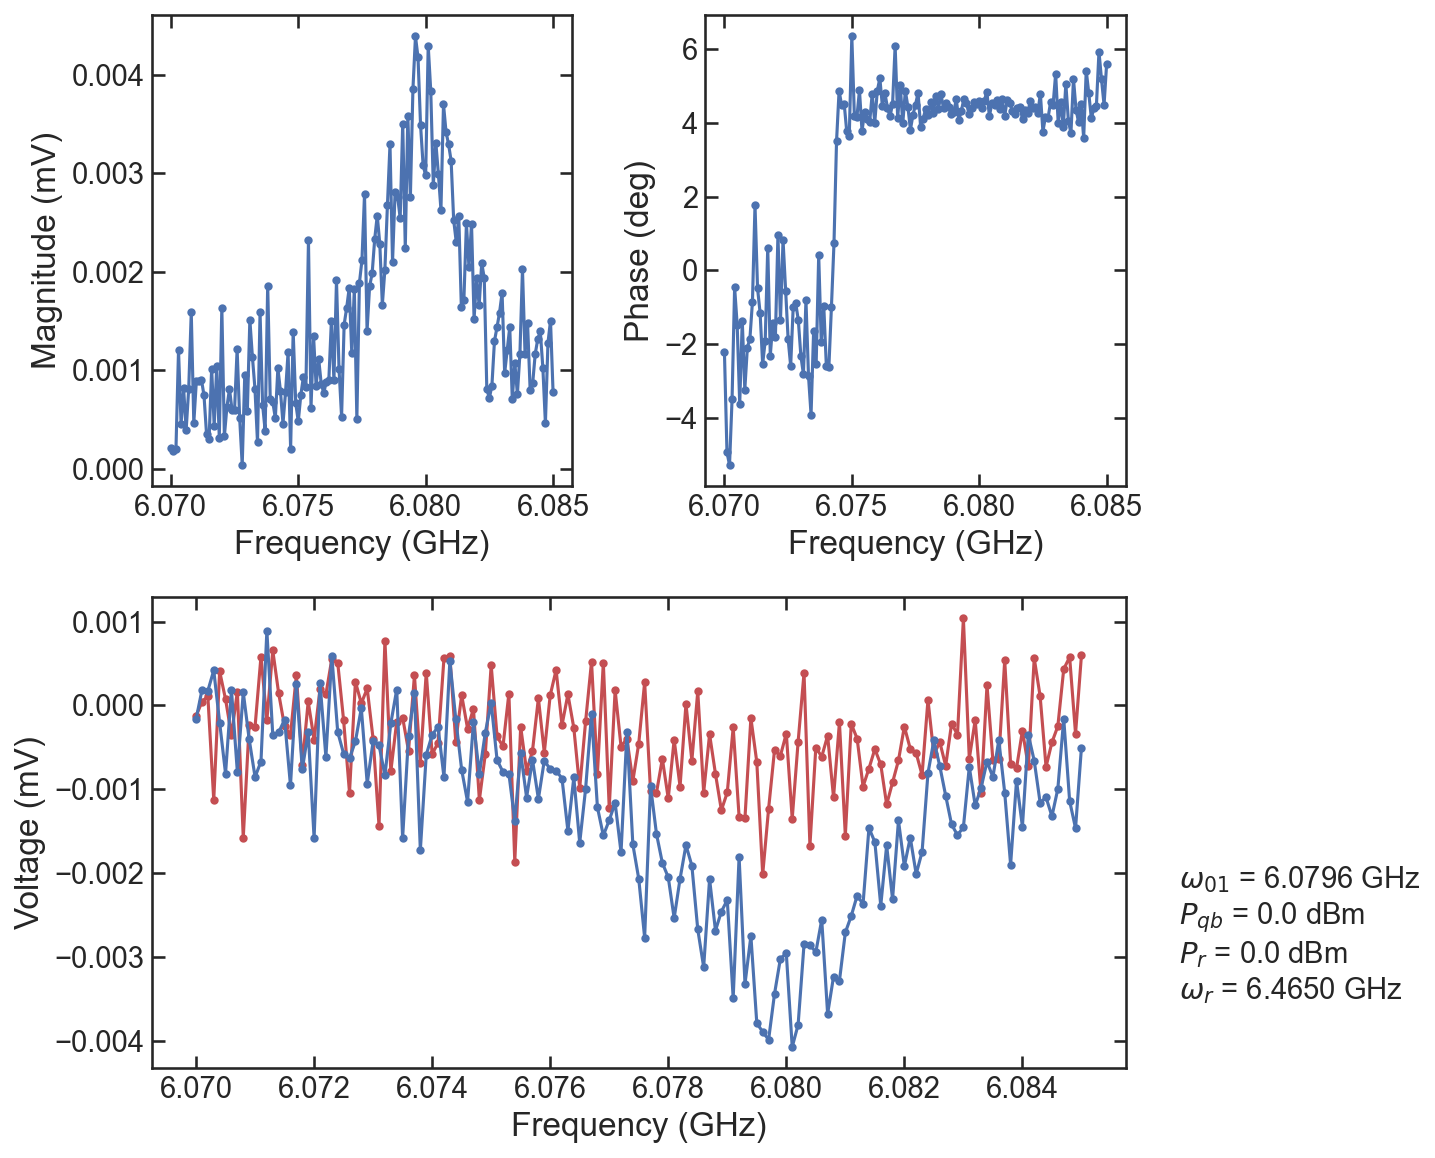

In [177]:
pf.qubit_spec_plot(data,qb_pars=qb.pars,find_peaks=True, amp_q_scaling=amp_q_scaling)

## Run broad spectroscopy scan on qubit

In [146]:
qb._instruments.set('sa','frequency',6e9)

Setting sa frequency to 6000000000.0.


In [147]:
qb.update_value('n_avg',5000)
qb.update_value('rr_freq', 6.464e9)
qb.update_value('rr_IF', 50e6)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(20e3)
qb.write_pars()
df_qubit_spec = 2e6
data, job = qb.run_scan(df = df_qubit_spec, element='qubit',
                                check_mixers=False,
                                chunksize = 200e6,
                                lo_min = 5e9,
                                lo_max = 6e9,
                                amp_q_scaling = 1,
                                on_off=True,
                                saturation_dur = 20e3,                   
                                showprogress=True,
                                savedata=False)

Updating n_avg to 5000
Updating rr_freq to 6464000000.0
Updating rr_IF to 50000000.0
Updating rr_LO to 6414000000.0
Setting readout_LO frequency to 6414000000.0.


  0%|          | 0/6 [00:00<?, ?it/s]

Updating qubit_LO to 5000000000.0
Setting qubit_LO frequency to 5000000000.0.
2024-04-05 13:05:37,057 - qm - INFO     - Performing health check
2024-04-05 13:05:37,069 - qm - INFO     - Health check passed
2024-04-05 13:05:37,174 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 13:05:37,275 - qm - INFO     - Executing program


 17%|█▋        | 1/6 [01:25<07:07, 85.45s/it]

Updating qubit_LO to 5200000000.0
Setting qubit_LO frequency to 5200000000.0.
2024-04-05 13:07:02,493 - qm - INFO     - Performing health check
2024-04-05 13:07:02,522 - qm - INFO     - Health check passed
2024-04-05 13:07:02,626 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 13:07:02,912 - qm - INFO     - Executing program


 17%|█▋        | 1/6 [01:28<07:21, 88.33s/it]


KeyboardInterrupt: 

Peak threshold at 0.0031648036885937687
Peaks at: 6.08 GHz



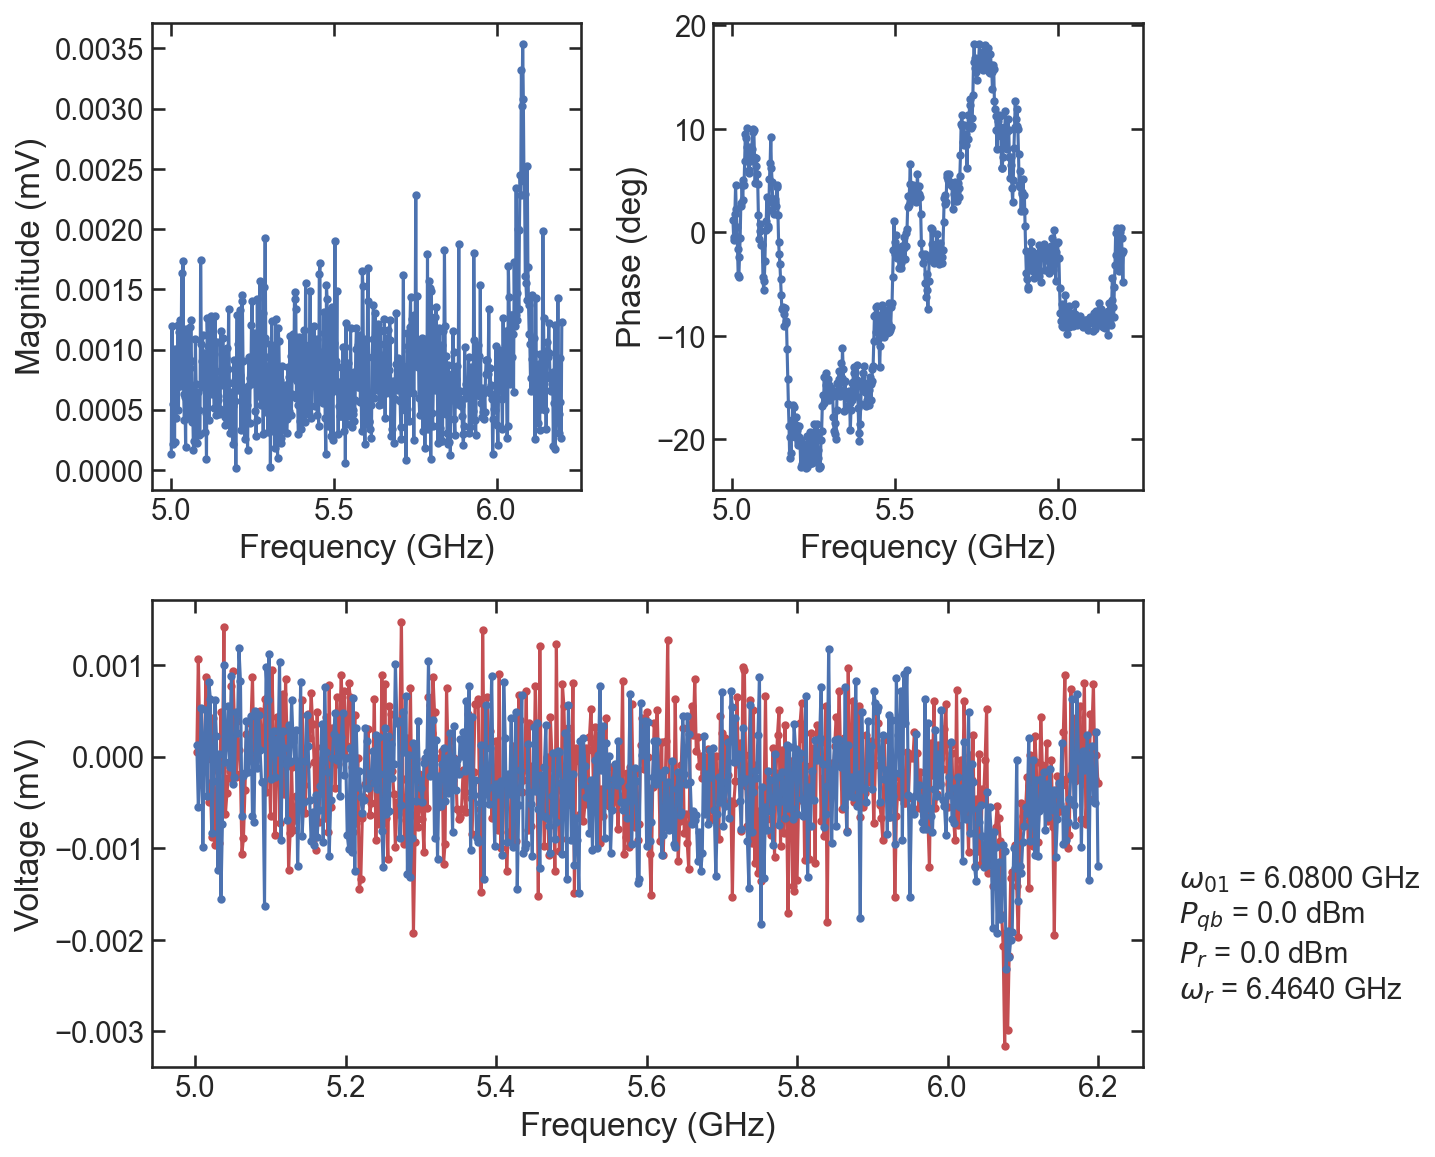

In [144]:
pf.qubit_spec_plot(data,qb_pars=qb.pars,df=df_qubit_spec,rrFreq=qb.pars['rr_freq'],amp_q_scaling=1)

In [140]:
data['freqs']

[5050000000.0,
 5100000000.0,
 5150000000.0,
 5200000000.0,
 5250000000.0,
 5300000000.0,
 5350000000.0,
 5400000000.0,
 5450000000.0,
 5500000000.0,
 5550000000.0,
 5600000000.0,
 5650000000.0,
 5700000000.0,
 5750000000.0,
 5800000000.0,
 5850000000.0,
 5900000000.0,
 5950000000.0,
 6000000000.0,
 6050000000.0,
 6100000000.0,
 6150000000.0,
 6200000000.0]